<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/Digits_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Digits with random sampling**

## **Connect to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd gdrive/My Drive/Project/active_learning

In [ ]:
pip install modal

## **Load library and digits data**

In [91]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import statistics

from sklearn.datasets import load_digits
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from dataclasses import dataclass

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


## **Load, Train and Split data**

In [5]:
digits = load_digits()

# array to save number of instance and accuracy result
instance_number = []
accuracy_result = []

# flatten into 1d array
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
Y = digits.target

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)


In [6]:
# data_points 100,...,900
data_points=range(100,1000,100)

# train a classifier and predict
def train_and_predict(n_instances, X_train, y_train, X_test):
    clf = RandomForestClassifier()
    
    dataset_size = len(X_train)
    potential_candidates = list(range(dataset_size))
    train_indexes = np.array(random.sample(potential_candidates, n_instances))
    #print(train_indexes)
    clf.fit(X_train[train_indexes], y_train[train_indexes])
    predicted = clf.predict(X_test)
    return predicted

def random_selection_learning(n_instances, X_train, y_train):
    clf = RandomForestClassifier()
    X_selected, X_not_selected, y_selected, y_not_selected = \
        train_test_split(X_train, y_train, train_size=n_instances, shuffle=True)
    clf.fit(X_selected, y_selected)
    return clf, X_selected, X_not_selected, y_selected, y_not_selected

In [93]:
def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    #print(f"{accuracy}")
    return accuracy

@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    print("n_new_samples ",n_new_samples)
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

def uncertainty_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    #pass

def learning_curve(data_points, repeats, selection_policy):
    experiments = []
    mean_n100 = []
    mean_n = []
    for i in range(repeats):
        # First learn 
        n_samples = data_points[0]
        print("n_samples",n_samples)
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train)
        acc = evaluate(model, X_test, y_test)
        experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
        mean_n100.append(acc)
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
            
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
            print(X_selected.shape, y_selected.shape)
            model.fit(X_selected, y_selected)
            acc = evaluate(model, X_test, y_test)
            experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
            mean_n.append(acc)
            
    #print("mean n 100", mean_n100)
    #print(mean_n)
    return experiments, mean_n, mean_n100

experiments, mn, res_arr_100 = learning_curve(data_points,10, random_sampling_policy)
print(experiments)
print("Non-100 array",mn)

n_samples 100
n_new_samples  100
(200, 64) (200,)
n_new_samples  100
(300, 64) (300,)
n_new_samples  100
(400, 64) (400,)
n_new_samples  100
(500, 64) (500,)
n_new_samples  100
(600, 64) (600,)
n_new_samples  100
(700, 64) (700,)
n_new_samples  100
(800, 64) (800,)
n_new_samples  100
(900, 64) (900,)
n_samples 100
n_new_samples  100
(200, 64) (200,)
n_new_samples  100
(300, 64) (300,)
n_new_samples  100
(400, 64) (400,)
n_new_samples  100
(500, 64) (500,)
n_new_samples  100
(600, 64) (600,)
n_new_samples  100
(700, 64) (700,)
n_new_samples  100
(800, 64) (800,)
n_new_samples  100
(900, 64) (900,)
n_samples 100
n_new_samples  100
(200, 64) (200,)
n_new_samples  100
(300, 64) (300,)
n_new_samples  100
(400, 64) (400,)
n_new_samples  100
(500, 64) (500,)
n_new_samples  100
(600, 64) (600,)
n_new_samples  100
(700, 64) (700,)
n_new_samples  100
(800, 64) (800,)
n_new_samples  100
(900, 64) (900,)
n_samples 100
n_new_samples  100
(200, 64) (200,)
n_new_samples  100
(300, 64) (300,)
n_new_sa

In [ ]:
def mean_stdev(res_arr_100):
  avg = statistics.mean(res_arr_100)
  stdev = statistics.stdev(res_arr_100)

  return avg, stdev

def get_array_avg_stdev(mn_len,repeat,mn):
  res = []
  for i in range(repeat):
    res.append(detail_get_array_avg_stdev(i,mn_len,mn))

  return res

def detail_get_array_avg_stdev(start,mn_len,mn):
  rn = range(start,mn_len,2)
  arr = []
  res = []
  for x in rn:
    arr.append(mn[x])
  avg = statistics.mean(arr)
  stdev = statistics.stdev(arr)
  
  res.append(arr)
  res.append(avg)
  res.append(stdev)

  return res

def getarray(arr,repeat):
  res_getarray = []
  for i in range(repeat):
    res_getarray.append(arr[i][0])

  return res_getarray

def getavg(arr,repeat):
  res_getavg = []
  for i in range(repeat):
    res_getavg.append(arr[i][1])

  return res_getavg

def get_stdev(arr,repeat):
  res_getstdev = []
  for i in range(repeat):
    res_getstdev.append(arr[i][2])

  return res_getstdev

mn_len = len(mn)
print("mean non-100 len array", mn_len)
# dp_len = len(data_points)
# print("dp len", dp_len)
dp_len = len(data_points)-1

res_avg_100, res_stdev_100 = mean_stdev(res_arr_100)

# get non-100 array, average and stdev (bulk)
bulk = get_array_avg_stdev(mn_len,dp_len,mn)
print("bulk",bulk)

# get non-100 array
bulk_array = getarray(bulk,dp_len)
print("bulk array",bulk_array)

# get non-100 avg
bulk_avg = getavg(bulk,dp_len)
print("bulk avg",bulk_avg)

# get non-100 stdev
bulk_stdev = get_stdev(bulk,dp_len)
print("bulk stdev",bulk_stdev)

# Complete the uncertainty_sampling_policy
# experiments = learning_curve(data_points, 4, uncertainty_sampling_policy)
# print(experiments)

get percentile 25 [0.9377777777777777, 0.9483333333333334, 0.94, 0.9511111111111111, 0.94, 0.953888888888889, 0.94, 0.9533333333333334]
st dev [0.0183646  0.01397823 0.01835925 0.01396991 0.01860463 0.01405857
 0.01881406 0.01424323]
bulk stdev [0.018364602531705253, 0.01397823116499573, 0.018359249121086038, 0.013969909135002734, 0.018604625688502578, 0.014058565264363939, 0.018814058137425142, 0.014243227731201583]


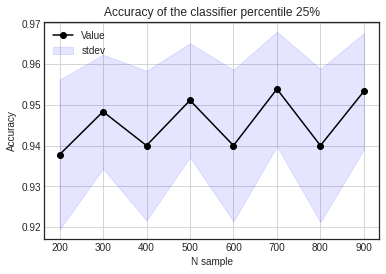

In [94]:
# calculate 25% percentiles
def get_percentile25(arr,repeat):
  res_getpercentile25 = []
  for i in range(repeat):
    x = np.percentile(arr[i],25)
    res_getpercentile25.append(x)
  return res_getpercentile25
bulk_getpercentile25 = get_percentile25(bulk_array,dp_len)
print("get percentile 25", bulk_getpercentile25)

# plot median
xpoints = np.array([200,300,400,500,600,700,800,900])
ypoints = np.array([bulk_getpercentile25[i] for i in range(dp_len)])
# ymean = np.array([bulk_avg[i] for i in range(dp_len)])
# print("ymean",ymean)
error = np.array([bulk_stdev[i] for i in range(dp_len)])
print("st dev",error)

with plt.style.context('seaborn-white'):
   plt.title('Accuracy of the classifier percentile 25%')
   plt.plot(xpoints,ypoints, label='Value', marker='o',color='k')

   # show standard deviation
   plt.fill_between(xpoints, ypoints-error, ypoints+error,color='blue',alpha=0.1,label='stdev')

   #plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
   plt.legend(loc='upper left')
   plt.xlabel("N sample")
   plt.ylabel("Accuracy")
   plt.grid()
   plt.show()

get median [0.9533333333333334, 0.96, 0.9533333333333334, 0.96, 0.9544444444444444, 0.961111111111111, 0.9533333333333334, 0.96]
st dev [0.0183646  0.01397823 0.01835925 0.01396991 0.01860463 0.01405857
 0.01881406 0.01424323]
bulk stdev [0.018364602531705253, 0.01397823116499573, 0.018359249121086038, 0.013969909135002734, 0.018604625688502578, 0.014058565264363939, 0.018814058137425142, 0.014243227731201583]


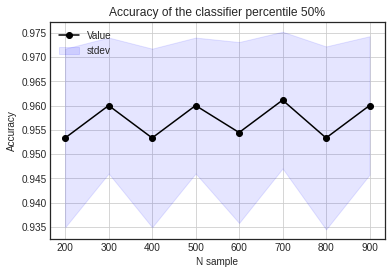

In [95]:
# calculate median (50% percentiles)
def get_median(arr,repeat):
  res_getmedian = []
  for i in range(repeat):
    x = np.percentile(arr[i],50)
    res_getmedian.append(x)
  return res_getmedian
bulk_getmedian = get_median(bulk_array,dp_len)
print("get median", bulk_getmedian)


# plot median
xpoints = np.array([200,300,400,500,600,700,800,900])
ypoints = np.array([bulk_getmedian[i] for i in range(dp_len)])
# ymean = np.array([bulk_avg[i] for i in range(dp_len)])
# print("ymean",ymean)
error = np.array([bulk_stdev[i] for i in range(dp_len)])
print("st dev",error)

with plt.style.context('seaborn-white'):
   plt.title('Accuracy of the classifier percentile 50%')
   plt.plot(xpoints,ypoints, label='Value', marker='o',color='k')

   # show standard deviation
   plt.fill_between(xpoints, ypoints-error, ypoints+error,color='blue',alpha=0.1,label='stdev')

   #plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
   plt.legend(loc='upper left')
   plt.xlabel("N sample")
   plt.ylabel("Accuracy")
   plt.grid()
   plt.show()


get percentile 75 [0.9644444444444444, 0.9694444444444444, 0.9644444444444444, 0.97, 0.9644444444444444, 0.9705555555555556, 0.9644444444444444, 0.9711111111111111]
st dev [0.0183646  0.01397823 0.01835925 0.01396991 0.01860463 0.01405857
 0.01881406 0.01424323]
bulk stdev [0.018364602531705253, 0.01397823116499573, 0.018359249121086038, 0.013969909135002734, 0.018604625688502578, 0.014058565264363939, 0.018814058137425142, 0.014243227731201583]


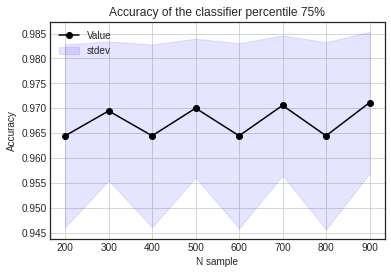

In [96]:
# calculate 75% percentiles
def get_percentile75(arr,repeat):
  res_getpercentile75 = []
  for i in range(repeat):
    x = np.percentile(arr[i],75)
    res_getpercentile75.append(x)
  return res_getpercentile75
bulk_getpercentile75 = get_percentile75(bulk_array,dp_len)
print("get percentile 75", bulk_getpercentile75)


# plot median
xpoints = np.array([200,300,400,500,600,700,800,900])
ypoints = np.array([bulk_getpercentile75[i] for i in range(dp_len)])
# ymean = np.array([bulk_avg[i] for i in range(dp_len)])
# print("ymean",ymean)
error = np.array([bulk_stdev[i] for i in range(dp_len)])
print("st dev",error)

with plt.style.context('seaborn-white'):
   plt.title('Accuracy of the classifier percentile 75%')
   plt.plot(xpoints,ypoints, label='Value', marker='o',color='k')

   # show standard deviation
   plt.fill_between(xpoints, ypoints-error, ypoints+error,color='blue',alpha=0.1,label='stdev')

   #plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
   plt.legend(loc='upper left')
   plt.xlabel("N sample")
   plt.ylabel("Accuracy")
   plt.grid()
   plt.show()

## N = 100

[0.8624444444444445, 0.8624444444444445, 0.8624444444444445, 0.8624444444444445, 0.8624444444444445, 0.8624444444444445, 0.8624444444444445, 0.8624444444444445, 0.8624444444444445, 0.8624444444444445]
[0.83555556 0.86444444 0.84222222 0.87111111 0.85333333 0.84222222
 0.89777778 0.88444444 0.87777778 0.85555556]
0.8624444444444445
Std dev:  0.020325202449061507


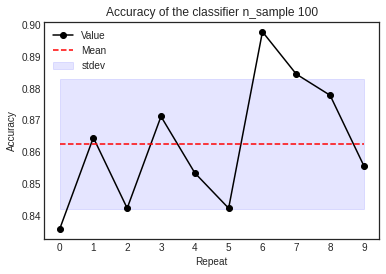

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

x_value = np.arange(0,len(res_arr_100),1)
xpoints = x_value
ypoints = np.array(res_arr_100)

x = x_value
y_mean = [res_avg_100]*len(x)
print(y_mean) 
print(ypoints)
print(res_avg_100)

with plt.style.context('seaborn-white'):
  fig,ax = plt.subplots()
  plt.title('Accuracy of the classifier n_sample 100')
  error = res_stdev_100
  print("Std dev: ", error)
  # Plot the data
  data_line = ax.plot(xpoints,ypoints, label='Value', marker='o',color='k')

  plt.fill_between(x, np.asarray(y_mean)-error, np.asarray(y_mean)+error,color='blue',alpha=0.1,label='stdev')

  # Plot the average line
  mean_line = ax.plot(x,y_mean, label='Mean', linestyle='--',color='r')

  # Make a legend
  legend = ax.legend(loc='upper left')

  # Make repeat int
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

  plt.xlabel("Repeat")
  plt.ylabel("Accuracy")
  plt.show()

## N = 200

[0.924, 0.924, 0.924, 0.924, 0.924, 0.924, 0.924, 0.924, 0.924, 0.924]
[0.94222222 0.92222222 0.92       0.92       0.93111111 0.94666667
 0.92222222 0.91333333 0.9        0.92222222]
0.924
Std dev:  0.013448066036041722


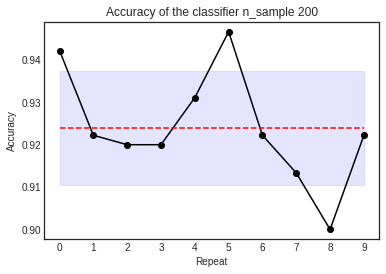

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

x_value = np.arange(0,len(res_arr_200),1)
xpoints = x_value
ypoints = np.array(res_arr_200)

x = x_value
y_mean = [res_avg_200]*len(x)
print(y_mean) 
print(ypoints)
print(res_avg_200)

with plt.style.context('seaborn-white'):
  fig,ax = plt.subplots()
  plt.title('Accuracy of the classifier n_sample 200')
  error = res_stdev_200
  print("Std dev: ", error)
  # Plot the data
  data_line = ax.plot(xpoints,ypoints, label='Value', marker='o',color='k')

  plt.fill_between(x, np.asarray(y_mean)-error, np.asarray(y_mean)+error,color='blue',alpha=0.1,label='stdev')

  # Plot the average line
  mean_line = ax.plot(x,y_mean, label='Mean', linestyle='--',color='r')

  # Make a legend
  #legend = ax.legend(loc='lower left')

  # Make repeat int
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

  plt.xlabel("Repeat")
  plt.ylabel("Accuracy")
  plt.show()

## N = 300

[0.9437777777777777, 0.9437777777777777, 0.9437777777777777, 0.9437777777777777, 0.9437777777777777, 0.9437777777777777, 0.9437777777777777, 0.9437777777777777, 0.9437777777777777, 0.9437777777777777]
[0.94666667 0.94888889 0.94444444 0.93777778 0.95777778 0.96222222
 0.94222222 0.92666667 0.92888889 0.94222222]
0.9437777777777777
Std dev:  0.01118739247291054


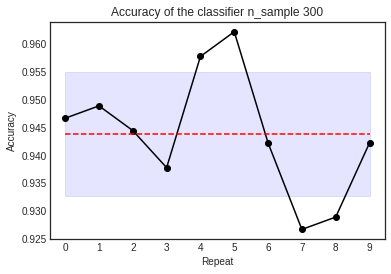

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

x_value = np.arange(0,len(res_arr_300),1)
xpoints = x_value
ypoints = np.array(res_arr_300)

x = x_value
y_mean = [res_avg_300]*len(x)
print(y_mean) 
print(ypoints)
print(res_avg_300)

with plt.style.context('seaborn-white'):
  fig,ax = plt.subplots()
  plt.title('Accuracy of the classifier n_sample 300')
  error = res_stdev_300
  print("Std dev: ", error)
  # Plot the data
  data_line = ax.plot(xpoints,ypoints, label='Value', marker='o',color='k')

  plt.fill_between(x, np.asarray(y_mean)-error, np.asarray(y_mean)+error,color='blue',alpha=0.1)

  # Plot the average line
  mean_line = ax.plot(x,y_mean, label='Mean', linestyle='--',color='r')

  # Make a legend
  #legend = ax.legend(loc='upper right')

  # Make repeat int
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

  plt.xlabel("Repeat")
  plt.ylabel("Accuracy")
  plt.show()

In [ ]:
n_samples = len(digits.images)

# n_data : [100,500,1000,1500]
n_data = 100
instance_number.append(n_data)

# flatten into 1d array
data = digits.images.reshape((n_samples, -1))

# calling a classifier
clf = RandomForestClassifier()

# split dataset into 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(
    data[:n_data], digits.target[:n_data], test_size=0.25, shuffle=False)

# train the classifier
clf.fit(X_train, y_train)

# get prediction
predicted = clf.predict(X_test)

## **Performance evaluation**

In [ ]:
print(f"{metrics.accuracy_score(y_test,predicted)}")
accuracy_result.append(f"{metrics.accuracy_score(y_test,predicted)}")

0.952


In [ ]:
print(instance_number)
print(accuracy_result)

[100, 500, 1000, 1500]
['1.0', '0.832', '0.944', '0.952']
